In [1]:
import os
from os import listdir
from os.path import isfile, isdir, join, getsize

import pandas as pd
import re
import numpy as np 

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import LinearLocator, FormatStrFormatter

from mpl_toolkits.mplot3d import Axes3D


In [120]:
db_log_dir = join('..', 'data', 'exp_logs-parallelizaton_exp', 'logs')
out_dir = join('..', 'plots', 'log_analysis')

In [3]:
isdir(db_log_dir)

True

In [4]:
all_files = listdir(db_log_dir)

In [5]:
interesting_log_files = [x for x in listdir(db_log_dir) if getsize(join(db_log_dir, x)) > 0]

In [6]:
interesting_log_files

['DyLDO-core-type-parallel_2-test-2_batch_11.log',
 'DyLDO-core-attribute-parallel_8-test-2_batch_22.log',
 'DyLDO-core-type-parallel_4-test-2_batch_17.log',
 'DyLDO-core-type-parallel_2-test-2_batch_38.log',
 'DyLDO-core-type-parallel_8-test-2_batch_31.log',
 'DyLDO-core-attribute-parallel_16-test-2_batch_4.log',
 'DyLDO-core-type-parallel_8-test-2_batch_20.log',
 'DyLDO-core-attribute-parallel_4-test-2_batch_40.log',
 'DyLDO-core-attribute-parallel_16-test-2_batch_25.log',
 'DyLDO-core-type-parallel_8-test-2_batch_12.log',
 'DyLDO-core-attribute-parallel_16-test-2_batch_2.log',
 'DyLDO-core-type-parallel_4-test-2_batch_31.log',
 'DyLDO-core-attribute-parallel_16-test-2_batch_18.log',
 'DyLDO-core-type-parallel_4-test-2_batch_2.log',
 'DyLDO-core-attribute-parallel_16-test-2_batch_16.log',
 'DyLDO-core-type-parallel_2-test-2_batch_14.log',
 'DyLDO-core-type-parallel_8-test-2_batch_27.log',
 'DyLDO-core-attribute-parallel_2-test-2_batch_36.log',
 'DyLDO-core-attribute-parallel_16-test-

In [7]:
stats = {}

df = pd.DataFrame(columns=['Dataset', 'Version', 'Model', 'Cores', 'Conflicts'])
for file in interesting_log_files:
    # DyLDO-core-attribute-parallel_16-test-2_batch_43
    z = re.match('(.*)(-.*)(-parallel)(_[0-9]+)(-test-[0-9])(_batch)?_([0-9]+)$', file.replace('.log', ''))
    # ('DyLDO-core', '-attribute', '-parallel', '_16', '-test-2', '_batch', '43')
    if len(z.groups()) != 7:
        display(z.groups())
        print(file)
    stats[file.replace('.log', '')] = {}
    conflicts = 0
    with open(join(db_log_dir, file), 'r') as log_file:
        lines = log_file.readlines()
        for line in lines:
            vs_id = line.split('[UPDATES]')[-1].replace('\n', '').strip()
            if vs_id in stats[file.replace('.log', '')]:
                stats[file.replace('.log', '')][vs_id] += 1
            else:
                stats[file.replace('.log', '')][vs_id] = 1
            conflicts += 1
        df = df.append({'Dataset': z.groups()[0], 
                        'Version': z.groups()[6], 
                        'Model': z.groups()[1][1::], 
                        'Cores': z.groups()[3][1::], 
                        'Conflicts': conflicts },ignore_index=True)

df['Cores'] = df['Cores'].astype('int')    

In [76]:
def my_3d_plot(x, y, values, plot_name, z_lim=None, save_dir=None):
    y_offset = 5
    
    # prepare data   
    X, Y = np.meshgrid(x, y)
    Z = np.transpose(np.array(values))
    #display(Y)
    
    fig = plt.figure()
    ax = Axes3D(fig)
      
    # plot the data
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, linewidth=0, antialiased=True)
    
    # add contour lines for readability
    #print(np.min(values[0]))
    """
    min_index = np.argmin(values[0])
    max_index = np.argmax(values[0])
    
    median_index = list(values[0]).index(np.percentile(values[0], 50, interpolation='nearest'))

    #print(median_index)
    lvls = [min_index, median_index, max_index]
    colors = ['darkslateblue', 'forestgreen', 'indianred']
    temp = list(zip(lvls, colors))
    temp.sort(key=lambda x: x[0])
    #display(temp)
    lvls, colors = zip(*temp)
    #display(lvls)
    #display(colors)
    
    # TODO: 40 is not displayed properly
    if lvls[2] == 40:
        lvls = list(lvls)
        lvls[2] = 39
    #lvls = [20,30,39]
    cset = ax.contour(X, Y, Z, zdir='y', levels=lvls, offset=-y_offset, colors=colors)
    """
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.0f'))

    #fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.title(plot_name)
    plt.xticks(x)
    ax.invert_xaxis()
    ax.view_init(35, 25)
    
    if z_lim:
        ax.set_zlim([0, z_lim])

    #ax.set_ylim([-y_offset, len(y)+y_offset])
    ax.set_ylim([-y_offset, len(y)+y_offset])
    
    ax.set_xlabel("Available cores", labelpad=10)
    ax.set_ylabel("GDB version", labelpad=10)

    ax.zaxis.set_rotate_label(False)  # disable automatic rotation
    ax.set_zlabel("Merge Conflicts", rotation=90, labelpad=10)
    
    #fig.colorbar.remove()
    
    if save_dir:
        plt.savefig(save_dir + '/' + plot_name.replace(' ', '-') + '-parallel.pdf',  bbox_inches='tight')
        plt.savefig(save_dir + '/' + plot_name.replace(' ', '-') + '-parallel.png',  bbox_inches='tight', dpi=300)
        
    plt.show()


,Dataset,Version,Model,Cores,Conflicts
Version,,,,,
0,DyLDO-core,0,attribute,2,16
0,DyLDO-core,0,type,16,11242
0,DyLDO-core,0,type,2,408
0,DyLDO-core,0,attribute,4,117
0,DyLDO-core,0,attribute,8,311
...,...,...,...,...,...
50,DyLDO-core,50,type,4,961
50,DyLDO-core,50,type,8,2980
50,DyLDO-core,50,attribute,2,17


Model: attribute
Cores: 2
Cores: 4
Cores: 8
Cores: 16
[2, 4, 8, 16]


[array([16, 24, 13, 20, 52,  9, 20, 17, 30, 32, 22, 47, 26, 28, 20, 18, 24,
        15, 21, 20, 27, 15, 45, 31, 20, 54, 97, 17, 60, 53, 33, 29, 22, 36,
        85, 39, 48, 30, 16, 22, 16, 16, 22, 58, 13, 24, 27, 25, 28, 17]),
 array([117,  94,  94, 110, 115,  99,  89,  78,  95, 125, 153, 127, 142,
        117, 124, 100, 107, 107, 111,  90, 151, 127, 144, 148, 132, 219,
        213, 214, 215, 204, 253, 217, 235, 230, 244, 223, 232, 196, 171,
        163, 165, 147, 161, 171, 117, 133, 126, 129, 139, 118]),
 array([311, 341, 336, 330, 354, 297, 265, 259, 291, 370, 419, 430, 366,
        393, 346, 296, 276, 277, 310, 250, 373, 322, 435, 412, 412, 638,
        607, 571, 581, 671, 640, 602, 568, 603, 590, 580, 606, 522, 480,
        458, 477, 405, 527, 449, 350, 350, 333, 346, 331, 354]),
 array([ 586,  580,  569,  606,  614,  628,  530,  559,  619,  793,  832,
         783,  805,  711,  778,  703,  587,  616,  543,  451,  697,  468,
         961,  623,  642,  912,  965,  940, 1343,  871,  9

[50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]


(4, 50)

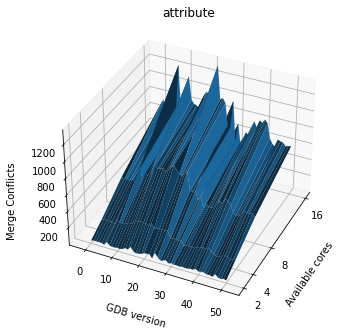

Model: type
Cores: 2
Cores: 4
Cores: 8
Cores: 16
skip due to shape missmatch (experiement incomplete?)
[2, 4, 8]


[array([408, 369, 328, 403, 339, 310, 351, 339, 343, 438, 425, 363, 517,
        417, 308, 446, 440, 438, 339, 313, 569, 399, 488, 535, 267, 671,
        529, 368, 513, 483, 685, 671, 619, 501, 647, 528, 504, 456, 476,
        517, 339, 477, 344, 226, 476, 276, 323, 350, 344, 291]),
 array([1150,  878, 1094, 1092,  959,  745,  994, 1024, 1163, 1027, 1295,
        1108, 1253, 1005,  894, 1158, 1146, 1145,  927,  987, 1345, 1227,
        1328, 1373, 1016, 1634, 1671, 1711, 1633, 1799, 1862, 1814, 1699,
        1609, 1613, 1694, 1600, 1275, 1407, 1420, 1102, 1293, 1093, 1121,
        1084,  798,  976,  982,  977,  961]),
 array([3691, 2838, 3722, 3634, 3017, 2299, 3209, 3232, 3534, 3374, 4468,
        3437, 4098, 3503, 2926, 3494, 3742, 3651, 2989, 3220, 4809, 3871,
        4612, 4421, 3303, 5653, 5579, 5684, 5753, 6322, 6204, 6183, 5730,
        5697, 5409, 5604, 5625, 4260, 4763, 4667, 3680, 3974, 3679, 3942,
        3559, 2387, 2963, 2942, 3032, 2980])]

[50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]


(3, 50)

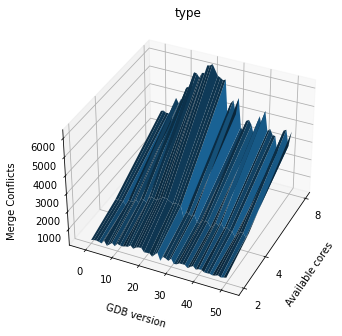

In [121]:
a_frame = df #df[df['Cores'] == cores]
a_frame.index = a_frame['Version'].astype(int)
a_frame.sort_index(inplace=True)
display(a_frame)
plot_frame = pd.DataFrame(columns=df['Model'].unique())
for model in df['Model'].unique():
    print('Model: %s' % model)
    a_frame = df[df['Model'] == model]
    #x = list(a_frame['Cores'].unique())
    x = []
    #display(len(x))
    values = []
    all_cores = list(a_frame['Cores'].unique())
    all_cores.sort()
    for core in all_cores:
        print('Cores: %s' % core)
        t_val_frame = a_frame[a_frame['Cores'] == core]
        #display(t_val_frame)
        t_vals = np.array(a_frame[a_frame['Cores'] == core]['Conflicts'].astype(int))
        if len(values) > 0 and len(t_vals) != len(values[0]):
            print('skip due to shape missmatch (experiement incomplete?)')
        else:
            values.append(t_vals)
            x.append(core)
            #display(t_vals)
    #x.reverse()
    print(x)
    #values.reverse()
    display(values)
    y = list(set(a_frame['Version'].astype(int)))
    y.reverse()
    print(y)
    display(np.array(values).shape)
    #values = np.array(df[['Cores', 'Conflicts']])
    my_3d_plot(x, y, values, model, z_lim=None, save_dir=out_dir)
    
    

Text(0.5, 1.0, 'type')

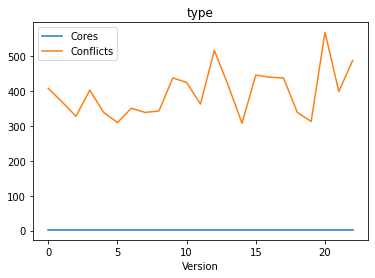

In [175]:
a_frame = df[df['Cores'] == 2]
ax = a_frame[a_frame['Model'] == 'type'].plot()
ax.set_title('type')

<AxesSubplot:>

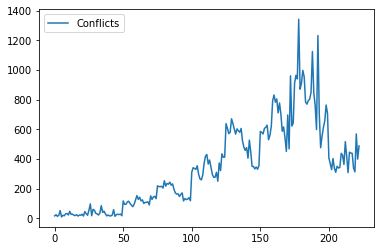

In [97]:

df.plot()

In [11]:
import re
asd = 'DyLDO-core-attribute-parallel_2-test-2_batch_0'

z = re.match('(.*)(-.*)(-parallel)(_[0-9]+)(-test-[0-9])(_batch)?_([0-9]+)$', asd)
z

<re.Match object; span=(0, 46), match='DyLDO-core-attribute-parallel_2-test-2_batch_0'>

In [12]:
z.groups()

('DyLDO-core', '-attribute', '-parallel', '_2', '-test-2', '_batch', '0')

In [13]:
z.groups()[1][1::]

'attribute'

In [88]:
# hot vertex summaries

display(stats)

{'DyLDO-core-type-parallel_2-test-2_batch_11': {'48': 360,
  '-2030505161': 2,
  '564491453': 1},
 'DyLDO-core-attribute-parallel_8-test-2_batch_22': {'-121913705': 16,
  '1383854819': 45,
  '-237374872': 39,
  '1535074497': 1,
  '1609285120': 2,
  '1109828132': 1,
  '1833646158': 5,
  '271392804': 13,
  '1413160744': 1,
  '1072875714': 1,
  '-1805512467': 42,
  '377543283': 3,
  '-212013139': 5,
  '1487371367': 1,
  '681013538': 3,
  '987914379': 1,
  '323493703': 1,
  '-1215354179': 4,
  '-1088303476': 24,
  '-1803393042': 5,
  '84571989': 3,
  '-2136415111': 1,
  '-909850869': 2,
  '-1040226662': 1,
  '1867149505': 2,
  '-442605031': 29,
  '937215393': 4,
  '941249740': 37,
  '1484281741': 2,
  '1206177804': 5,
  '-1293342406': 3,
  '1808603445': 3,
  '-1967559901': 5,
  '1747481197': 4,
  '-1436040256': 1,
  '-1147901181': 1,
  '561771513': 2,
  '-83855854': 1,
  '-1645511108': 2,
  '1838434056': 1},
 'DyLDO-core-type-parallel_4-test-2_batch_17': {'48': 1119,
  '1205067464': 2,
  '

In [99]:
display(sum(list(stats['DyLDO-core-type-parallel_8-test-2_batch_20'].values())))

4809

In [101]:
stats['DyLDO-core-type-parallel_8-test-2_batch_20']['48']/sum(list(stats['DyLDO-core-type-parallel_8-test-2_batch_20'].values()))

0.9787897691827823

In [196]:
no_types = []
no_properties = []
hot_summaries = {}
for key in stats.keys():
    if '48' in stats[key]:
        if 'type' in key:
            pass
        else:
            print('Other Collection!')
        no_types.append(stats[key]['48'] / sum(list(stats[key].values())))

    if '-1805512467' in stats[key]:
        if 'attribute' in key:
            pass
        else:
            print('Other Collection!')
        no_properties.append(stats[key]['-1805512467'] / sum(list(stats[key].values())))
        
        #data = list(stats[key].values())
    hot_id = max(stats[key], key=stats[key].get)
    hot_val = max(stats[key].values())
    
    if hot_id in hot_summaries:
        hot_summaries[hot_id].append(hot_val)
    else:
        hot_summaries[hot_id] = [hot_val]
    #hot_summaries.append([, max(stats[key].values())])
        #plt.hist(data, bins=len(data), alpha=0.5)
        #plt.show()
        #break
   
import statistics as st
print('___Update conflict share for 48 (no types)___')
print('Min: {:7.2f} %'.format(min(no_types) * 100))
print('Max: {:7.2f} %'.format(max(no_types) * 100))
print('Mean: {:6.2f} %'.format(st.mean(no_types)*100))
print('Std: {:7.2f} %'.format(st.stdev(no_types)*100))
print()
print('___Update conflict share for -1805512467 (no properties)___')
print('Min: {:7.2f} %'.format(min(no_properties) * 100))
print('Max: {:7.2f} %'.format(max(no_properties) * 100))
print('Mean: {:6.2f} %'.format(st.mean(no_properties)*100))
print('Std: {:7.2f} %'.format(st.stdev(no_properties)*100))
#display(hot_summaries)
print('_________')
for key in hot_summaries.keys():
    print('<{:11}>: {:7,} conflicts distributed over {:3,} different runs'.format(key, sum(hot_summaries[key]), len(hot_summaries[key])))

___Update conflict share for 48 (no types)___
Min:   94.98 %
Max:  100.00 %
Mean:  98.04 %
Std:    1.02 %

___Update conflict share for -1805512467 (no properties)___
Min:    4.27 %
Max:   43.91 %
Mean:  20.99 %
Std:    9.44 %
_________
<48         >: 339,095 conflicts distributed over 156 different runs
<1383854819 >:     289 conflicts distributed over   8 different runs
<-1805512467>:  12,563 conflicts distributed over 114 different runs
<9750618    >:   1,032 conflicts distributed over  35 different runs
<-237374872 >:   1,413 conflicts distributed over  38 different runs
<941249740  >:     522 conflicts distributed over   2 different runs
<-442605031 >:   1,000 conflicts distributed over   3 different runs


hot_summaries

* 48: no types
* -1805512467: no properties